## Initial preparations

In [299]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import functional as F

device = 'cuda' if torch.cuda else 'cpu'
device

'cuda'

## Dataset: Tiny Shakespeare

### Download

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [1]:
with open("input.txt", 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
print(len(text))

1115394


In [3]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



### Building vocabular

In [109]:
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print("".join(vocab))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### Tokenizing

Revise tokenisers:

- SentencePiece powered by Google
- TikToken

In [110]:
stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for i,ch in enumerate(vocab)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda L: [itos[i] for i in L]

print(encode("hello, world!"))
print(''.join(decode(encode("hello, world!"))))

[46, 43, 50, 50, 53, 6, 1, 61, 53, 56, 50, 42, 2]
hello, world!


In [111]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

### Train/Validation split

In [112]:
train_size = int(0.9*len(data))
train_X    = data[:train_size]
val_X      = data[train_size:]
print(train_size)

1003854


### Setup block_size - maximum context length

- context length - count of tokens in a continious line prior target token

In [113]:
block_size = 8
train_X[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [114]:
example_x = train_X[:block_size]
example_y = train_X[1:block_size+1]
for t in range(block_size):
    context = example_x[:t+1]
    target = example_y[t]
    print(f"when input is {context} the target is {target}")

when input is tensor([18]) the target is 47
when input is tensor([18, 47]) the target is 56
when input is tensor([18, 47, 56]) the target is 57
when input is tensor([18, 47, 56, 57]) the target is 58
when input is tensor([18, 47, 56, 57, 58]) the target is 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target is 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is 58


In [177]:
torch.manual_seed(1337)
batch_size = 4

def get_batch(split, batch_size=4):
    data = train_X if split == 'train' else val_X
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x  = torch.stack([data[i:i+block_size] for i in ix])
    y  = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


In [179]:
batch_size = 4
xb, yb = get_batch('train', batch_size)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[57, 43, 60, 43, 52,  1, 63, 43],
        [60, 43, 42,  8,  0, 25, 63,  1],
        [56, 42,  5, 57,  1, 57, 39, 49],
        [43, 57, 58, 63,  6,  1, 58, 46]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[43, 60, 43, 52,  1, 63, 43, 39],
        [43, 42,  8,  0, 25, 63,  1, 45],
        [42,  5, 57,  1, 57, 39, 49, 43],
        [57, 58, 63,  6,  1, 58, 46, 47]], device='cuda:0')
----
when input is [57] the target: 43
when input is [57, 43] the target: 60
when input is [57, 43, 60] the target: 43
when input is [57, 43, 60, 43] the target: 52
when input is [57, 43, 60, 43, 52] the target: 1
when input is [57, 43, 60, 43, 52, 1] the target: 63
when input is [57, 43, 60, 43, 52, 1, 63] the target: 43
when input is [57, 43, 60, 43, 52, 1, 63, 43] the target: 39
when input is [60] the target: 43
when input is [60, 43] the target: 42
when input is [60, 43, 42] the target: 8
when input is [60, 43, 42, 8] the target: 0
when input is [60, 43, 42, 8, 0

### Baseline: Bigram Language Model

In [268]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.tocken_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx):
        return self.tocken_embedding_table(idx).transpose(1,2)

    def compute_loss(self, logits, targets):
        return F.cross_entropy(logits, targets)

    def generate(self, initial_context, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(initial_context)
            last_time_step_logits = logits[:,:,-1]
            probs = F.softmax(last_time_step_logits, dim=1)
            context_next = torch.multinomial(probs, num_samples=1)
            initial_context = torch.cat((initial_context, context_next), dim=1)
        return initial_context

    def generate_string(self, initial_context, max_new_tokens):
        return ''.join(
            decode(
                self.generate(initial_context, max_new_tokens=max_new_tokens)[0].tolist()
            )
        )


m = BigramLanguageModel(vocab_size).to(device)
logits = m(xb)
loss = m.compute_loss(logits, yb)
print(logits.shape)
print(loss)

torch.Size([4, 65, 8])
tensor(4.6161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


In [269]:
-np.log(1/65)

4.174387269895637

In [270]:
initial_context = torch.zeros((1,1), dtype=torch.long, device=device)
print(m.generate_string(initial_context, max_new_tokens=100))


pYCXxfRkRZd
wc'wfNfT;OLlTEeC K
jxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a
hs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe


In [273]:
batch_size = 32
eval_iters = 200
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-2)
for steps in range(1000):
    xb, yb = get_batch("train")
    logits = m(xb)
    loss = m.compute_loss(logits, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

2.4974207878112793


In [274]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(m.generate_string(context, max_new_tokens=500))



S:
WARSwanousel lind me l.
MA:
TqVVchiry:
Supr aisspll, y.
Jllin'd noroopetelaves
Mk:
Gll, d motSSkllo W-wou wh tCoisb3s wouth dourivETENGShire s p-LOK:

PxTre

ALk dmnthrupt f s ar igis!
m:

Enge maleronth, af PRD?d my o myaHKINLIE!
Ktied&y, wardsal acesEDW:
Yovein cNIk ay aney Rry ts I&fr y c!
MykenEETon, bemary.
Yof 'WWh wne?m sora anghse.
Senomangqqur'e mrdand s st sulin s th llugivome.
I'duco fflomy ssthecas l.
TAnEnas d thapeanjuldse ed PRAUNTomoveveaimoCas!



Cos cok hed;KHoie s ingo he


### Denoise loss calculation

In [229]:
class LossEstimator:
    
    def __init__(self, eval_step):
        self.eval_step = eval_step

    @torch.no_grad()
    def estimate_loss(self, model):
        estimations = dict()
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(self.eval_step)
            for k in range(self.eval_step):
                X, y = get_batch(split)
                logits = model(X)
                loss = model.compute_loss(logits, y)
                losses[k] = loss.item()
            estimations[split] = losses.mean().item()
        model.train()
        return estimations

### Collect all the training stuff into a single method

It includes:
- average loss estimations through batch of samples
- average losses for both train and valdidation split
- Adam optimizer with weights penalty
- learning_rate decay on plateau

In [286]:
def train(model, iterations, batch_size, optimizer, lr_scheduler, loss_estimator):
    loss_history = {"train": [], "val": []} 
    for i in range(iterations):
        if i % loss_estimator.eval_step == 0:
            losses = loss_estimator.estimate_loss(model)
            print(f"step {i} losses:", end=" ") 
            for split, loss_value in losses.items():
                loss_history[split].append(loss_value)
                print(f"{split} {losses['train']:.4f},", end=" ")
            lr_scheduler.step(losses['train'])
            print()
        xb, yb = get_batch('train', batch_size)
        logits = model(xb)
        loss = model.compute_loss(logits, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return loss_history


In [304]:
model = BigramLanguageModel(vocab_size).to(device)
iterations = 10000
batch_size = 32
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
loss_estimator = LossEstimator(eval_step=200)

In [305]:
initial_context = torch.zeros((1,1), dtype=torch.long, device=device)
print(model.generate_string(initial_context, max_new_tokens=100))


3?HwJvZKaZuJ,&$W MAaneiPzkR'U.;UV
OaVpL'yTpj,xgjIdptl
 oCXcggB-FxpHMQfniMH tl-wl
SFPXZ$A,ES!nPHMzx d


In [306]:
loss_history = train(model, iterations, batch_size, optimizer, lr_scheduler, loss_estimator)

step 0 losses: train 4.7072, val 4.7072, 
step 200 losses: train 3.1370, val 3.1370, 
step 400 losses: train 2.6796, val 2.6796, 
step 600 losses: train 2.5587, val 2.5587, 
step 800 losses: train 2.5431, val 2.5431, 
step 1000 losses: train 2.4892, val 2.4892, 
step 1200 losses: train 2.4822, val 2.4822, 
step 1400 losses: train 2.5131, val 2.5131, 
step 1600 losses: train 2.4906, val 2.4906, 
step 1800 losses: train 2.4550, val 2.4550, 
step 2000 losses: train 2.4731, val 2.4731, 
step 2200 losses: train 2.4599, val 2.4599, 
step 2400 losses: train 2.4552, val 2.4552, 
step 2600 losses: train 2.4546, val 2.4546, 
step 2800 losses: train 2.4469, val 2.4469, 
step 3000 losses: train 2.4620, val 2.4620, 
step 3200 losses: train 2.4748, val 2.4748, 
step 3400 losses: train 2.4550, val 2.4550, 
step 3600 losses: train 2.4600, val 2.4600, 
step 3800 losses: train 2.4710, val 2.4710, 
step 4000 losses: train 2.4498, val 2.4498, 
step 4200 losses: train 2.4744, val 2.4744, 
step 4400 losses:

In [307]:
print(model.generate_string(initial_context, max_new_tokens=500))


lyong ho ndrkeloiobote fe, orsthy ben; and thead avendesithacest g.
Wigofoth I sar Thampe st Go mee bo akeacthivel my nevet gn chy lthit berat ald ilyeniclouthenen Handurped wany rvoaraipoubitis.

Se chafy ny m. air'thooutharasu to s un the d assthoror Soue.
PENUS:
S:
MISe been, Huthes, GBerf; jeo n w, t wipsttiours and!
Agunca!
Hers hited tows.
Tes orry s chat; tun WAnoovengs thethe INTond t hingede th y, manof tche s GENG y set:
Tor iveie bengaspankll yor,

Whes s anonme at d
Alan;
Sun ced;
Th


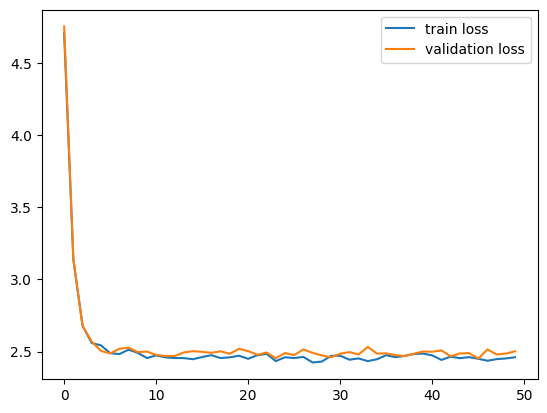

In [308]:
fig, ax_l = plt.subplots(1, 1)
ax_l.plot(np.array(loss_history["train"]).flatten(), label = 'train loss')
ax_l.plot(np.array(loss_history["val"]).flatten(), label = 'validation loss')
ax_l.legend()